# Diabetic Retinopathy 

Diabetic retinopathy (DR), also known as diabetic eye disease, is a medical condition in which damage occurs to the retina due to diabetes mellitus. It is a leading cause of blindness. Diabetic retinopathy affects up to 80 percent of those who have had diabetes for 20 years or more. Diabetic retinopathy often has no early warning signs. **Retinal (fundus) photography with manual interpretation is a widely accepted screening tool for diabetic retinopathy**, with performance that can exceed that of in-person dilated eye examinations. 

The below figure shows an example of a healthy patient and a patient with diabetic retinopathy as viewed by fundus photography ([source](https://www.biorxiv.org/content/biorxiv/early/2018/06/19/225508.full.pdf)):

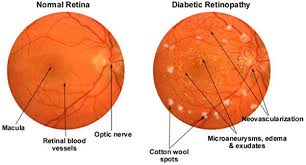

An automated tool for grading severity of diabetic retinopathy would be very useful for accerelating detection and treatment. Recently, there have been a number of attempts to utilize deep learning to diagnose DR and automatically grade diabetic retinopathy. This includes this [competition](https://kaggle.com/c/diabetic-retinopathy-detection) and [work by Google](https://ai.googleblog.com/2016/11/deep-learning-for-detection-of-diabetic.html). Even one deep-learning based system is [FDA approved](https://www.fda.gov/NewsEvents/Newsroom/PressAnnouncements/ucm604357.htm). 

Clearly, this dataset and deep learning problem is quite well-characterized. 

# A look at the data:

Data description from the competition:

>You are provided with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. >Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is the left eye of patient id 1).
>
>A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:
>
>0 - No DR
>
>1 - Mild
>
>2 - Moderate
>
>3 - Severe
>
>4 - Proliferative DR
>
>Your task is to create an automated analysis system capable of assigning a score based on this scale.

...

> Like any real-world data set, you will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. A major aim of this competition is to develop robust algorithms that can function in the presence of noise and variation.

**A minor problem!**

Due to the large image file size, there are **only 1000 files with labels** and one csv file with the labels of all the images in the directory available in the kernel, as demonstrated below. The actual competition had on the order of 35,000 files so this is clearly **a very small subset of the data**. 
In addition, this is a highly imbalanced dataset. 

Originally, I had aimed to create a model that would be close to the SOTA, but clearly, with only 1000 images that's not possible.

**AIM OF KERNEL:** I will utilize transfer learning, oversampling, and progressive resizing on this small, imbalanced dataset.
Given that many real-world datasets are also small and imbalanced, it will be interesting to see how far these techniques will take us.

In [ ]:
import torch

torch.cuda.is_available()

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
import itertools
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.data import Dataset
from skimage.io import imread
from sklearn.metrics import *
from sklearn.model_selection import *
from skimage.io import *
from glob import glob
import warnings


warnings.filterwarnings('ignore')
print("Necessary modules have been imported")


In [ ]:
# 定義圖像解析函數
def parse_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    return image, label

# 定義數據集加載函數
def load_dataset(file_paths, labels, batch_size=32):
    dataset = Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(file_paths)).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


## Importing labels

In [ ]:
# 解壓和加載數據標籤
!unzip -o ../input/diabetic-retinopathy-detection/trainLabels.csv.zip
trainLabels = pd.read_csv("./trainLabels.csv")


In [ ]:
!apt install p7zip-full -y
!7z x ../input/diabetic-retinopathy-detection/train.zip.001 "-i!train/11*.jpeg" -y 
# restrict extracted file to about 100 for the disk restriction
!mkdir data
!mv train data/train_11


In [ ]:
# 獲取所有圖像文件路徑
file_paths = glob("./data/train_11/*.jpeg")

# 假設file_paths包含圖像的完整路徑，從中提取圖像的基礎名稱
file_basenames = [os.path.basename(f).replace(".jpeg", "") for f in file_paths]

# 根據文件名來篩選出對應的標籤
filtered_labels = trainLabels[trainLabels['image'].isin(file_basenames)]['level'].values

# 確認file_paths與filtered_labels的數量相同
print(f"Number of image files: {len(file_paths)}")
print(f"Number of filtered labels: {len(filtered_labels)}")

# 加載數據集
dataset = load_dataset(file_paths, filtered_labels)

In [ ]:
# 定義顯示批量圖像的函數
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(5):  # 顯示5張圖片
        ax = plt.subplot(1, 5, n + 1)
        plt.imshow(image_batch[n])
        plt.title(int(label_batch[n]))
        plt.axis("off")
    plt.show()

# 過濾出每個類別的一張圖片
def get_images_by_label(dataset, num_classes=5):
    images = [None] * num_classes  # 用None初始化一個大小為num_classes的列表
    labels = [None] * num_classes
    label_counts = {i: 0 for i in range(num_classes)}  # 用來追蹤每個類別已經收集到的圖片數量

    for image_batch, label_batch in dataset:
        for img, lbl in zip(image_batch, label_batch):
            label = int(lbl)
            if label_counts[label] == 0:  # 只收集一次該類別的圖片
                images[label] = img
                labels[label] = lbl
                label_counts[label] += 1
            if sum(label_counts.values()) == num_classes:  # 如果已經收集到每個類別一張圖片，退出
                return np.array(images), np.array(labels)
    return np.array(images), np.array(labels)

# 從數據集中獲取每個類別的圖片
image_batch, label_batch = get_images_by_label(dataset)

# 按照類別順序排列圖片和標籤
sorted_indices = np.argsort(label_batch)
image_batch = image_batch[sorted_indices]
label_batch = label_batch[sorted_indices]

# 顯示批量圖像
show_batch(image_batch, label_batch)


## Filtering csv file

In [ ]:
# Filtering and Balancing Data
base_image_dir = os.path.join('.', 'data/train_11')
trainLabels['path'] = trainLabels['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
trainLabels['exists'] = trainLabels['path'].map(os.path.exists)  # Filter out missing images
df = trainLabels[trainLabels['exists']]
df = df.drop(columns=['image', 'exists'])
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle dataframe
df['level'] = df['level'].astype(str)
df.head(10)

In [ ]:
# Visualize distribution
df['level'].hist(figsize=(10, 5))


**The dataset is highly imbalanced, with many samples for level 0, and very little for the rest of the levels.**

## CNN Model

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Conv2D, multiply, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import numpy as np
from tensorflow.keras.utils import plot_model

def create_deeper_attention_model(input_shape, num_classes):
    in_lay = Input(input_shape)
    base_pretrained_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    base_pretrained_model.trainable = False  # 保持大部分預訓練層凍結
    pt_depth = base_pretrained_model.output_shape[-1]
    pt_features = base_pretrained_model(in_lay)
    
    bn_features = BatchNormalization()(pt_features)
    
    # 注意力機制並加上正則化
    attn_layer = Conv2D(128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(Dropout(0.5)(bn_features))
    attn_layer = Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(attn_layer)
    attn_layer = Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(attn_layer)
    attn_layer = Conv2D(1, kernel_size=(1,1), padding='valid', activation='sigmoid')(attn_layer)
    
    up_c2_w = np.ones((1, 1, 1, pt_depth))
    up_c2 = Conv2D(pt_depth, kernel_size=(1,1), padding='same', activation='linear', use_bias=False, weights=[up_c2_w])
    up_c2.trainable = False
    attn_layer = up_c2(attn_layer)
    
    mask_features = multiply([attn_layer, bn_features])
    gap_features = GlobalAveragePooling2D()(mask_features)
    gap_mask = GlobalAveragePooling2D()(attn_layer)
    
    gap = Lambda(lambda x: x[0]/x[1], name='RescaleGAP')([gap_features, gap_mask])
    gap_dr = Dropout(0.5)(gap)  # 增加Dropout比例
    dr_steps = Dropout(0.5)(Dense(256, activation='relu', kernel_regularizer=l2(0.001))(gap_dr))  # 增加全連接層的單元數
    out_layer = Dense(num_classes, activation='softmax')(dr_steps)
    
    model = Model(inputs=[in_lay], outputs=[out_layer])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy','AUC'])
    
    return model

# 使用 create_attention_model 函數來創建注意力模型
attention_model = create_deeper_attention_model((256, 256, 3), 5)  # 有5個類別
attention_model.summary()

# 繪製模型架構圖
plot_model(attention_model, show_shapes=True, show_layer_names=True, dpi=60, to_file='model_architecture.png')


 **Model Training with Stratified K-Fold Cross-Validation and Epoch Incrementing**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Initialize lists to store fold results
all_train_accu = []
all_val_accu = []
all_train_loss = []
all_val_loss = []
all_train_auc = []
all_val_auc = []
all_history = {'categorical_accuracy': [], 'val_categorical_accuracy': [], 
               'loss': [], 'val_loss': [], 'auc': [], 'val_auc': []}

# Balance data function
def balance_data(class_size, df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace=True)).reset_index(drop=True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize=(10, 5))
    return train_df

# Initialize StratifiedKFold
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize cumulative confusion matrix
cumulative_cm = None

# Iterate through each fold
for fold_index, (train_index, val_index) in enumerate(skf.split(df, df['level'])):
    print(f"Training fold {fold_index + 1}/{n_splits}")

    # Split data into training and validation sets
    train_df, val_df = df.iloc[train_index], df.iloc[val_index]

    # Ensure balanced class distribution
    max_class_size = train_df.pivot_table(index='level', aggfunc=len).max().max()
    train_df = balance_data(max_class_size, train_df)

    # ImageDataGenerator for training and validation
    train_datagen = ImageDataGenerator(rescale=1.0/255, shear_range=0.2, horizontal_flip=True, zoom_range=0.2)
    test_datagen = ImageDataGenerator(rescale=1.0/255)

    x_train = train_datagen.flow_from_dataframe(train_df, directory=".", x_col="path", y_col="level", target_size=(256, 256), batch_size=32, class_mode='categorical')
    x_test = test_datagen.flow_from_dataframe(val_df, x_col="path", y_col="level", directory=".", target_size=(256, 256), batch_size=32, class_mode='categorical')

    # Initialize cumulative confusion matrix
    if cumulative_cm is None:
        cumulative_cm = np.zeros((len(x_train.class_indices), len(x_train.class_indices)), dtype=int)

    # Create and train the model
    attention_model = create_deeper_attention_model((256, 256, 3), len(x_train.class_indices))
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    filepath = f"dr-detector-fold{fold_index + 1}-{current_time}-{{epoch:02d}}-{{val_categorical_accuracy:.2f}}.hdf5"

    # Callbacks
    checkpoint = ModelCheckpoint(filepath, monitor="val_categorical_accuracy", verbose=1, save_best_only=True, mode="max")
    earlystop = EarlyStopping(monitor='val_categorical_accuracy', verbose=1, min_delta=0, patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.1, patience=7, min_delta=0.0001, cooldown=0, min_lr=1e-7)
    callbacks = [checkpoint, earlystop, reduce_lr]

    # Train the model
    history = attention_model.fit(x_train, steps_per_epoch=x_train.samples // 32, epochs=10, validation_data=x_test, validation_steps=x_test.samples // 32, callbacks=callbacks)

    # Evaluate the model
    result_train = attention_model.evaluate(x_train)
    result_test = attention_model.evaluate(x_test)
    train_loss, train_accu, train_auc = result_train
    test_loss, test_accu, test_auc = result_test

    # Store results
    all_train_accu.append(train_accu)
    all_val_accu.append(test_accu)
    all_train_loss.append(train_loss)
    all_val_loss.append(test_loss)
    all_train_auc.append(train_auc)
    all_val_auc.append(test_auc)

    all_history['categorical_accuracy'].append(history.history['categorical_accuracy'])
    all_history['val_categorical_accuracy'].append(history.history['val_categorical_accuracy'])
    all_history['loss'].append(history.history['loss'])
    all_history['val_loss'].append(history.history['val_loss'])
    all_history['auc'].append(history.history['auc'])
    all_history['val_auc'].append(history.history['val_auc'])

    # Generate predictions and compute confusion matrix
    y_pred_train = attention_model.predict(x_train)
    y_pred_train = np.argmax(y_pred_train, axis=1)
    y_true_train = x_train.classes
    cm_train = confusion_matrix(y_true_train, y_pred_train)
    cumulative_cm += cm_train

    print(f"Final training accuracy for fold {fold_index + 1} = {train_accu * 100:.2f}%, validation accuracy = {test_accu * 100:.2f}%")
    print(f"Final training loss = {train_loss:.2f}, validation loss = {test_loss:.2f}")
    print(f"Final training AUC = {train_auc:.2f}, validation AUC = {test_auc:.2f}")

# Calculate mean and standard deviation for all metrics
mean_train_accu = np.mean(all_train_accu)
mean_val_accu = np.mean(all_val_accu)
mean_train_loss = np.mean(all_train_loss)
mean_val_loss = np.mean(all_val_loss)
mean_train_auc = np.mean(all_train_auc)
mean_val_auc = np.mean(all_val_auc)

std_train_accu = np.std(all_train_accu)
std_val_accu = np.std(all_val_accu)
std_train_loss = np.std(all_train_loss)
std_val_loss = np.std(all_val_loss)
std_train_auc = np.std(all_train_auc)
std_val_auc = np.std(all_val_auc)

# Print overall results
print("\nOverall Results:")
print(f"Mean training accuracy = {mean_train_accu * 100:.2f}% ± {std_train_accu * 100:.2f}%")
print(f"Mean validation accuracy = {mean_val_accu * 100:.2f}% ± {std_val_accu * 100:.2f}%")
print(f"Mean training loss = {mean_train_loss:.2f} ± {std_train_loss:.2f}")
print(f"Mean validation loss = {mean_val_loss:.2f} ± {std_val_loss:.2f}")
print(f"Mean training AUC = {mean_train_auc:.2f} ± {std_train_auc:.2f}")
print(f"Mean validation AUC = {mean_val_auc:.2f} ± {std_val_auc:.2f}")

# Visualize mean results over all folds
mean_history = {key: np.mean(np.array(all_history[key]), axis=0) for key in all_history.keys()}
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(mean_history['categorical_accuracy'], label='Train Accuracy')
plt.plot(mean_history['val_categorical_accuracy'], label='Test Accuracy')
plt.title('Average Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(mean_history['loss'], label='Train Loss')
plt.plot(mean_history['val_loss'], label='Test Loss')
plt.title('Average Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(mean_history['auc'], label='Train AUC')
plt.plot(mean_history['val_auc'], label='Test AUC')
plt.title('Average Model AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(loc='upper left')

plt.show()


In [ ]:
from matplotlib.colors import LinearSegmentedColormap  # Add this import
# Compute and visualize the average confusion matrix
average_cm = cumulative_cm / n_splits
target_names = list(x_train.class_indices.keys())

colors = [(0.8, 1, 0.8), (0.7, 0.9, 1)]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

plt.figure(figsize=(8, 8))
plt.imshow(average_cm, interpolation='nearest', cmap=cmap)
plt.title('Average Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=90)
plt.yticks(tick_marks, target_names)

for i, j in itertools.product(range(average_cm.shape[0]), range(average_cm.shape[1])):
    plt.text(j, i, format(average_cm[i, j], '.2f'), horizontalalignment="center", color="black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Completion message
print("All folds completed.")
